## A SIMPLE TRANSLATOR MODEL

#### This model translate english text to netherlands 

In [24]:
#file preprocessing
from io import open
import unicodedata
import re
from sklearn.model_selection import train_test_split

#creating model
import random
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

#time calculating
import time
import math

#visualization of attention
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

#score calculating
import nltk
from nltk.translate.bleu_score import sentence_bleu

#warnings
import warnings

#default settings
warnings.filterwarnings("ignore")
%matplotlib inline
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
SOS_token = 0
EOS_token = 1
DATA_DIR = 'data/eng-nld/%s-%s.txt'
MAX_LENGTH = 10
HIDDEN_SIZE = 128
TEACHER_FORCING_RATIO = 0.5
RANDOM_STATE = 42
BATCH_SIZE = 1024

# Data preprocessing

In [3]:
# Creating language vocabulary class 

class LangVocab:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS",}
        self.n_words = 2  

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [4]:
# Cleaning text

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

def cleanText(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [5]:
# Reading and cleaning data from txt file

def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    lines = open(DATA_DIR % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    pairs = [[cleanText(s) for s in l.split('\t')[:2]] for l in lines]
    
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        source = LangVocab(lang2)
        target = LangVocab(lang1)
    else:
        source = LangVocab(lang1)
        target = LangVocab(lang2)

    return source, target, pairs

In [6]:
# Filter text with MAX_LENGTH

def filterPair(pair):
    return len(pair[0].split(' ')) < MAX_LENGTH and \
        len(pair[1].split(' ')) < MAX_LENGTH


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [7]:
# Main function for preparing data

def prepareData(lang1, lang2, reverse=False):
    source, target, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        source.addSentence(pair[0])
        target.addSentence(pair[1])
    print("Counted words:")
    print(source.name, source.n_words)
    print(target.name, target.n_words)
    return source, target, pairs


source, target, pairs = prepareData('eng', 'nld', False)
print(random.choice(pairs),random.choice(pairs))

Reading lines...
Read 75298 sentence pairs
Trimmed to 62261 sentence pairs
Counting words...
Counted words:
eng 8801
nld 12596
['she committed suicide by hanging herself .', 'ze pleegde zelfmoord door zich te verhangen .'] ['they are good people .', 'zij zijn goede mensen .']


# Creating SEQ2SEQ model

In [8]:
# Encoder class

class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

In [0]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

In [9]:
# AttentionalDecoder class

class AttentionalDecoder(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttentionalDecoder, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

In [0]:
# Basic function

def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(source, pair[0])
    target_tensor = tensorFromSentence(target, pair[1])
    return (input_tensor, target_tensor)

In [10]:
# Creating dataset

def get_dataloader(batch_size):

    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(source, inp)
        tgt_ids = indexesFromSentence(target, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return train_dataloader

# Training model

In [11]:
# Training one epoch

def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [12]:
# Basic function for time

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [13]:
# Function for showing loss

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [14]:
# Function for showing attention 

def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


In [15]:
# Training function

def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  
    plot_loss_total = 0  

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

# Testing model

In [16]:
# Translate sentences

def translate(encoder, decoder, sentence):
    with torch.no_grad():
        input_tensor = tensorFromSentence(source, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                break
            decoded_words.append(target.index2word[idx.item()])
    return decoded_words, decoder_attn

In [17]:
# Translate random sentences

def translateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = translate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        showAttention(pair[0], output_words, attentions[0, :len(output_words), :])
        print('')

0m 54s (- 53m 10s) (5 1%) 3.5036
1m 46s (- 51m 14s) (10 3%) 2.3777
2m 38s (- 50m 4s) (15 5%) 1.7806
3m 31s (- 49m 22s) (20 6%) 1.3874
4m 26s (- 48m 53s) (25 8%) 1.0986
5m 21s (- 48m 13s) (30 10%) 0.8902
6m 13s (- 47m 7s) (35 11%) 0.7435
7m 6s (- 46m 11s) (40 13%) 0.6379
7m 58s (- 45m 13s) (45 15%) 0.5618
8m 52s (- 44m 22s) (50 16%) 0.5040
9m 44s (- 43m 23s) (55 18%) 0.4598
10m 38s (- 42m 34s) (60 20%) 0.4233
11m 31s (- 41m 40s) (65 21%) 0.3937
12m 26s (- 40m 51s) (70 23%) 0.3679
13m 19s (- 39m 58s) (75 25%) 0.3459
14m 12s (- 39m 5s) (80 26%) 0.3268
15m 7s (- 38m 15s) (85 28%) 0.3094
15m 59s (- 37m 19s) (90 30%) 0.2942
16m 53s (- 36m 27s) (95 31%) 0.2800
17m 46s (- 35m 33s) (100 33%) 0.2678
18m 39s (- 34m 39s) (105 35%) 0.2564
19m 33s (- 33m 46s) (110 36%) 0.2459
20m 26s (- 32m 52s) (115 38%) 0.2364
21m 18s (- 31m 57s) (120 40%) 0.2274
22m 11s (- 31m 3s) (125 41%) 0.2193
23m 3s (- 30m 9s) (130 43%) 0.2117
23m 56s (- 29m 15s) (135 45%) 0.2045
24m 50s (- 28m 23s) (140 46%) 0.1977
25m 45s 

<Figure size 640x480 with 0 Axes>

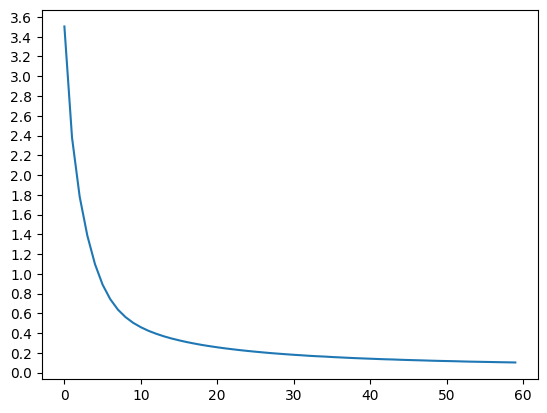

In [18]:
train_dataloader = get_dataloader(BATCH_SIZE)

encoder = Encoder(source.n_words, HIDDEN_SIZE).to(device)
decoder = AttentionalDecoder(HIDDEN_SIZE, target.n_words).to(device)

train(train_dataloader, encoder, decoder, 300, print_every=5, plot_every=5)

> i can t remember .
= ik kan het niet herinneren .
< ik kan me je niet herinneren herinneren .


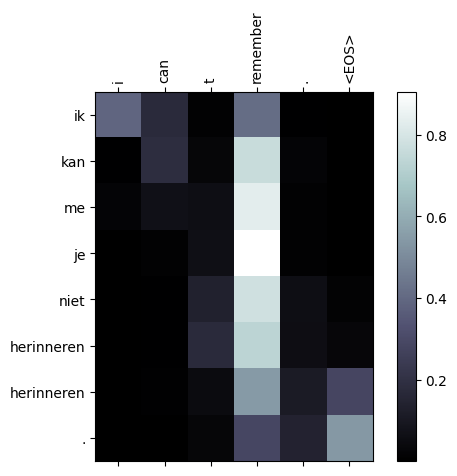


> didn t tom tell you his password ?
= heeft tom je zijn wachtwoord niet verteld ?
< heeft tom je zijn wachtwoord niet verteld ?


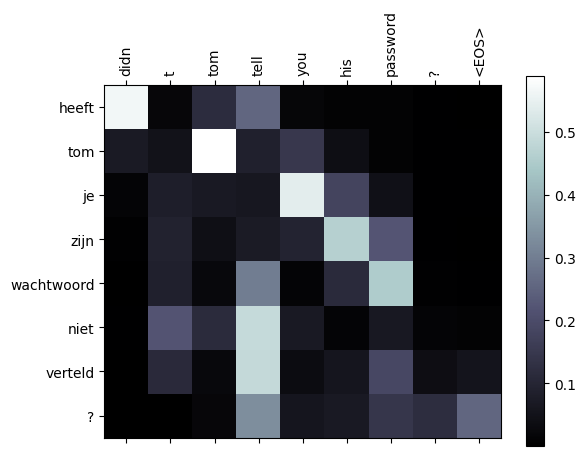


> i wasn t raised that way .
= ik ben niet zo opgevoed .
< ik ben niet zo opgevoed .


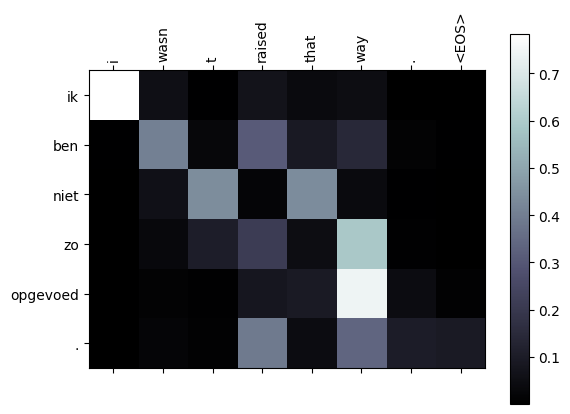


> i met him yesterday .
= ik ontmoette hem gisteren .
< ik ontmoette hem gisteren gisteren terug .


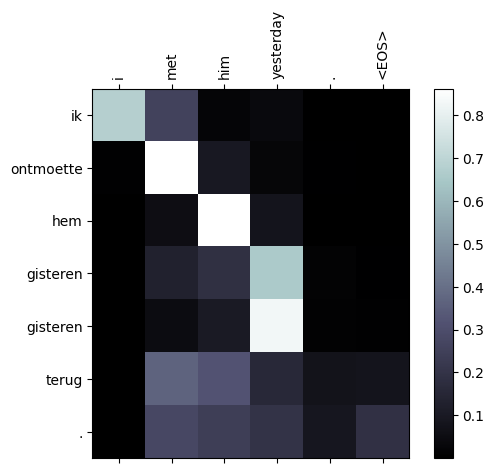


> nothing ventured nothing gained .
= niet geschoten is altijd mis .
< niets geschoten is altijd mis niet .


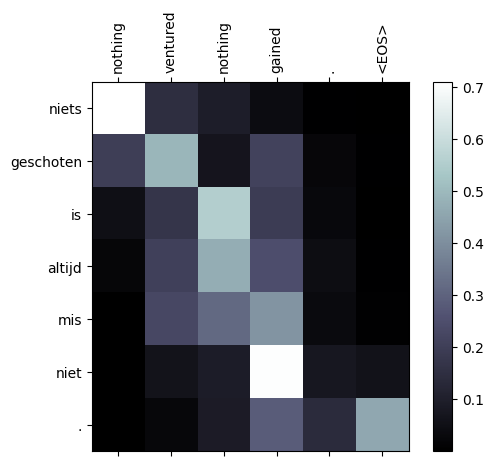


> that ll be hard .
= dat zal moeilijk worden .
< dat zal moeilijk worden te zijn .


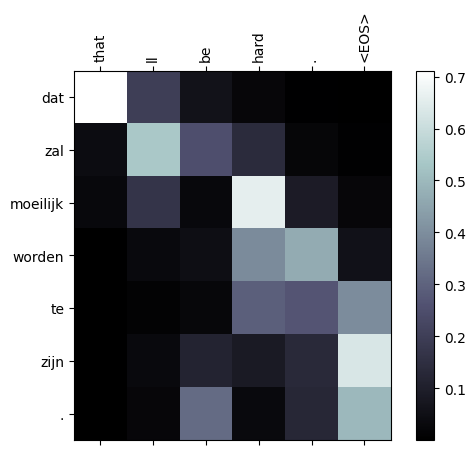


> tom still has a lot to learn .
= tom heeft nog veel te leren .
< tom heeft nog veel te leren .


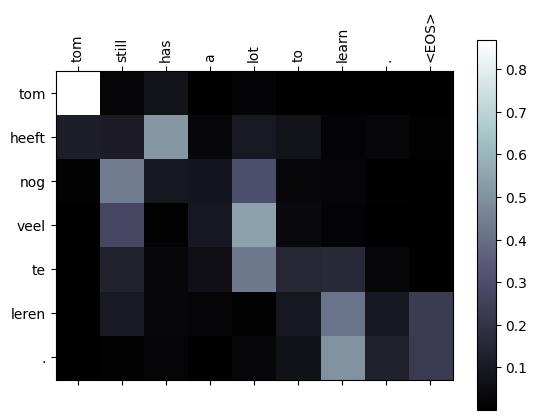


> they kissed .
= zij zoenden .
< zij zoenden ze elkaar .


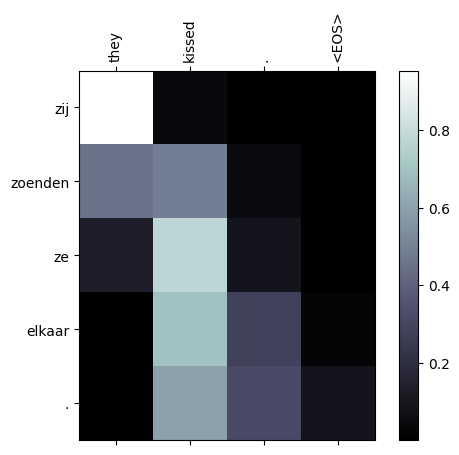


> don t go off without saying good by .
= ga niet weg zonder gedag te zeggen .
< ga niet weg zonder gedag te zeggen .


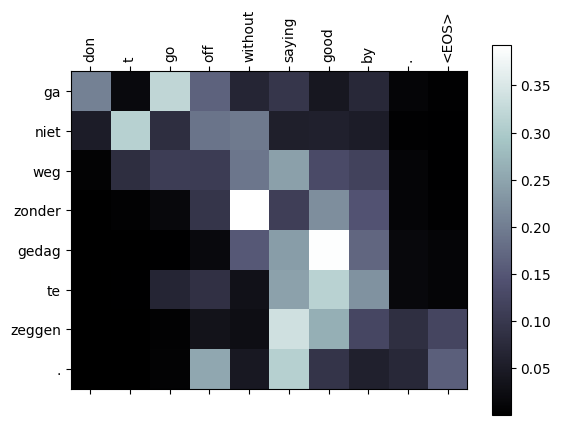


> tom doesn t like speaking french .
= tom spreekt niet graag frans .
< tom spreekt niet graag frans als frans .


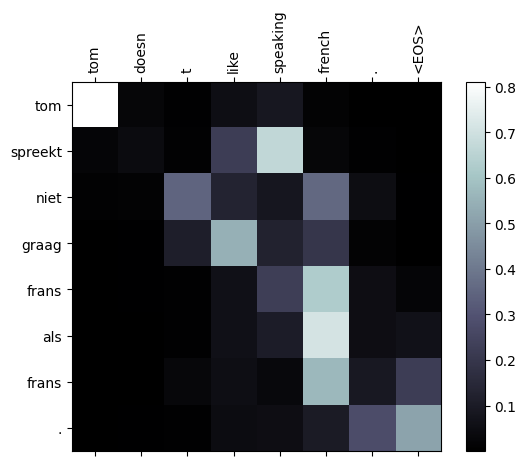

In [19]:
encoder.eval()
decoder.eval()
translateRandomly(encoder, decoder)

In [20]:
# Choose random pairs and making test

def testSpliting(pairs):
    test_pairs = []
    for i in range(1000):
         test_pairs.append(random.choice(pairs))
    return test_pairs

# Calculating score

In [21]:
# Calculating bleu score

def calculateScore(encoder,decoder,pairs):
    bleu_scores = []
    reference = [pair[1].split(' ') for pair in pairs] 
    
    for pair in pairs:
        candidate, _ = translate(encoder, decoder, pair[0]) 
        
        score = sentence_bleu(reference,candidate)
        bleu_scores.append(score)
    
    return (sum(bleu_scores)/len(pairs))*100


# Results

In [22]:
test_pairs = testSpliting(pairs)

In [23]:
print('BLEU score: {} %'.format(round(calculateScore(encoder,decoder,test_pairs)),2))

BLEU score: 51 %
